In [1]:
#------------------------------------------------------------------------------------------------------------------------------
# Import dependencies
#------------------------------------------------------------------------------------------------------------------------------
import re
import json
import sys, os

import requests
import psycopg2
import spotipy
import circlify
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from pprint import pprint
from copy import deepcopy
from IPython import display
from spotipy.oauth2 import SpotifyClientCredentials


warnings.filterwarnings("ignore")

In [2]:
#------------------------------------------------------------------------------------------------------------------------------
# Low level fns
#------------------------------------------------------------------------------------------------------------------------------
"""put in artist name returns url for image"""
def getArtistImage(artist):
    cid = '230cf876831c41f98414cd63f527ab1e'
    secret = 'c51e114110164f03a228031a53f56c87'
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    results = sp.search(q=artist, limit=1)['tracks']['items'][0]['album']['artists'][0]['id']
    artistImageUrl = sp.artist(results)['images'][0]['url']
    return artistImageUrl


def makeCircle(artist1,artist2):
    myName = []
    myPop = []
    myArtist = []

    try:
        artist = artist1
        tot_d = {}
        limit = 10
        urlraw = f'http://ws.audioscrobbler.com/2.0/?method=artist.gettopalbums&artist={artist1}&api_key=70894b101e887cf7fd9443bd5067f675&format=json&limit={limit}'

        r = requests.get(urlraw)
        tmp = r.json()
        # pprint(tmp)

        data = {}
        for i in range(limit):
            data[tmp['topalbums']['album'][i]['name']] = tmp['topalbums']['album'][i]['playcount']
        # print(data)

        names = list(data.keys())
        values = list(data.values())

        #plt.show()

        tot_d[artist] = sum(values)
        myDf = pd.Series(data).to_frame()#, orient='index')
        #print(myDf)
        myDf = myDf.sort_values(by=[0], ascending=False)
        for i in range(5):
            newName = myDf.index[i]
            newSong = (myDf[0][i])
            myName.append(newName)
            myPop.append(newSong)
            myArtist.append(artist1)

    except:
        print(f'your artist ({artist1}) is WRONG')

    try:
        artist = artist2
        tot_d = {}
        limit = 10
        urlraw = f'http://ws.audioscrobbler.com/2.0/?method=artist.gettopalbums&artist={artist2}&api_key=70894b101e887cf7fd9443bd5067f675&format=json&limit={limit}'

        r = requests.get(urlraw)
        tmp = r.json()
        # pprint(tmp)

        data = {}
        for i in range(limit):
            data[tmp['topalbums']['album'][i]['name']] = tmp['topalbums']['album'][i]['playcount']
        # print(data)

        names = list(data.keys())
        values = list(data.values())

        #plt.show()

        tot_d[artist] = sum(values)
        myDf = pd.Series(data).to_frame()#, orient='index')
        #print(myDf)
        myDf = myDf.sort_values(by=[0], ascending=False)
        for i in range(5):
            newName = myDf.index[i]
            newSong = (myDf[0][i])
            myName.append(newName)
            myPop.append(newSong)
            myArtist.append(artist2)

    except:
        print(f'your artist ({artist2}) is WRONG')

#     print(myName)
#     print(myPop)
#     print(myArtist)
    myCircleDf = pd.DataFrame({
    'Name': myName,
    'Value': myPop,
    'Artist' : myArtist})
    return(myCircleDf)


"""gives circle graph of top albums"""
def makeCircleGraph(myCircleDf):
    myCircleDf = myCircleDf.sort_values(by=['Value'], ascending=True)
    #print(myCircleDf)
    #print(myCircleDf['Value'].tolist())
    #print(myCircleDf['Name'].tolist())

    circles = circlify.circlify(
        myCircleDf['Value'].tolist(), 
        show_enclosure=True, 
        target_enclosure=circlify.Circle(x=0, y=0, r=1)
    )
    circles

    # Create just a figure and only one subplot
    fig, ax = plt.subplots(figsize=(10,10))

    # Title
    ax.set_title(f"TOP ALBUMS - {myCircleDf['Artist'][0]} vs. {myCircleDf['Artist'][9]}")

    # Remove axes
    ax.axis('off')

    # Find axis boundaries
    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # list of labels
    labels = myCircleDf['Name']
    art1 = myCircleDf['Artist'][0]
    art2 = myCircleDf['Artist'][9]
    arts = myCircleDf['Artist']

    # print circles
    for circle, label, art in zip(circles, labels, arts):
        if art == art1:
            x, y, r = circle
            ax.add_patch(plt.Circle((x, y), r,facecolor="#e3122e", alpha=0.2, linewidth=2))
            plt.annotate(
                  label, 
                  (x,y ) ,
                  va='center',
                  ha='center')
        else:
            x, y, r = circle
            ax.add_patch(plt.Circle((x, y), r,facecolor="#102ede", alpha=0.2, linewidth=2))
            plt.annotate(
                  label, 
                  (x,y ) ,
                  va='center')


"""gives bar graph of top albums and announce winner"""
def albumsplaycount(artist, code):
    tot_d = {}
    
    try:
        limit = 10
        urlraw = f'http://ws.audioscrobbler.com/2.0/?method=artist.gettopalbums&artist={artist}&api_key=70894b101e887cf7fd9443bd5067f675&format=json&limit={limit}'

        r = requests.get(urlraw)
        tmp = r.json()
        # pprint(tmp)

        data = {}
        for i in range(limit):
            data[tmp['topalbums']['album'][i]['name']] = tmp['topalbums']['album'][i]['playcount']
        # print(data)
    except:
        if artist == '':
            pass
        else:
            print(f'your artist ({artist}) is WRONG')
    else:
        names = list(data.keys())
        values = list(data.values())
#         print(data)

        fig, ax = plt.subplots()
        
        ax.set_title(f'TOP ALBLUMS & PLAYCOUNT - {artist}')
        ax.bar(range(len(data)), values, tick_label=names, color=code)
        
        ax.set_xticklabels(names, rotation = 90)
        ax.ticklabel_format(axis='y', style='plain')
        ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: format(int(y), ',')))

        plt.show()
        
        tot_d[artist] = sum(values)
    finally:
        return tot_d

    
"""gives dict of sim songs"""   
def get_sim_songs(artist, song):
    urlraw = f'https://ws.audioscrobbler.com/2.0/?method=track.getsimilar&artist={artist}&track={song}&api_key=70894b101e887cf7fd9443bd5067f675&format=json'

    dicy = {}

    r = requests.get(urlraw)
    tmp = r.json()
#     pprint(tmp)

    for i in range(len(tmp['similartracks']['track'])):
        songname = tmp['similartracks']['track'][i]['name']
        artistname = tmp['similartracks']['track'][i]['artist']['name']
#         print(f'{artistname}|{songname}')

        dicy[f'{artistname}|{songname}'] = 1

    return dicy


"""gives dict of sim artists""" 
def get_sim_artists(artist):
    urlraw = f'http://ws.audioscrobbler.com/2.0/?method=artist.getsimilar&artist={artist}&api_key=70894b101e887cf7fd9443bd5067f675&format=json'

    dicy = {}

    r = requests.get(urlraw)
    tmp = r.json()
#     pprint(tmp)

    for i in range(len(tmp['similarartists']['artist'])):
        artistname = tmp['similarartists']['artist'][i]['name']
#         print(artistname)

        dicy[f'{artistname}'] = 1

    return dicy
    

"""gives matching dict of two dicts"""
def match(dicy0, dicy1):   # 
    pot = {}
    
    for k0 in dicy0:
        for k1 in dicy1:
            if k0 == k1:
                pot[k1] = 1

    return pot


"""adds new sim songs by specified pair"""
def add_more(dicy, n):
    pair = list(dicy)[n]
#     print(pair)
    
    if '|' in pair:
        artistpair = pair.split('|')[0]
        songpair = pair.split('|')[1]
        
        try:
            dicypair = get_sim_songs(artistpair, songpair)
#             print(dicypair)
        
            dicynew = {**dicy, **dicypair}
        except:
            dicynew = dicy
        
#             print(f'FAILED searching... {pair}')
    else:
        artistpair = pair
        
        try:
            dicypair = get_sim_artists(artistpair)
#             print(dicypair)
        
            dicynew = {**dicy, **dicypair}
        except:
            dicynew = dicy

    
    return dicynew, pair


def iteration(dicy0, dicy1, hist0={}, hist1={}, debug=False):  
    #---------------------------------------------------------
    # check if sets inital match
    #---------------------------------------------------------
    res = match(dicy0, dicy1)

    if len(res) >= 1:
        
        if debug == True:
            print(len(res), res)
            print(f'stop after add 0 pair(s)')
            
        pass
    #---------------------------------------------------------
    # expand song by song until match
    #---------------------------------------------------------
    else:
        for i in range(max(len(dicy0), len(dicy1))):
            ind0 = 'n'
            ind1 = 'n'

            try:
                test0 = list(dicy0)[i]
            except:
                test0 = ''

            try:
                test1 = list(dicy1)[i]
            except:
                test1 = ''

            if test0.strip() and test0 not in hist0:
                dicy0, pair0 = add_more(dicy0, i)

#                 print('dicy0',len(dicy0))

                hist0[pair0] = 1

                ind0 = 'y'

            if test1.strip() and test1 not in hist1:
                dicy1, pair1 = add_more(dicy1, i)

#                 print('dicy1', len(dicy1))

                hist1[pair1] = 1

                ind1 = 'y'

            if not (ind0 == 'n' and ind1 == 'n'):
                res = match(dicy0, dicy1)

                if len(res) >= 1:
                    
                    if debug == True:
                        print(len(res), res)
                        print(f'stop after add {i + 1} pair(s)')
                        
                    break

    res = {ky: res[ky] for ky in list(res.keys())[:10]}                
                    
    return res, dicy0, dicy1, hist0, hist1    

In [3]:
#------------------------------------------------------------------------------------------------------------------------------
# high level fns
#------------------------------------------------------------------------------------------------------------------------------   
"""gives all artists with search"""    
def search_sim_artist(artist):
    params = {
        'host': 'localhost',
        'database': 'artistsbio_db',
        'user': 'postgres',
        'password': 'Cw18745.,'
    }
    conn = psycopg2.connect(**params)

    with conn:
#         sql = f"select artistname from public.glbartistbio where artistname ~* '{artist}' limit 5;"
        sql = f"select artistname from glbartistbio where artistname ~* '{artist}' and artistname !~* 'feat|ft.|,|&' \
            order by playcount::int desc limit 5;"
        
        cur = conn.cursor()
        cur.execute(sql)

    print('ARE YOU SEARCHING FOR?')
    for r in cur:
        artistname = r[0]
        print(r[0])

    cur.close()

    conn.commit()
    conn.close()
    
    
"""gives all artsists details with search"""
def search_artist_bio(artist):
    params = {
    'host': 'localhost',
    'database': 'artistsbio_db',
    'user': 'postgres',
    'password': 'Cw18745.,'
    }
    conn = psycopg2.connect(**params)

    with conn:
#         sql = f"select artistname from public.glbartistbio where artistname ~* '{artist}' limit 5;"
        sql = f"select * from glbartistbio where artistname ~* '{artist}' and artistname !~* 'feat|ft.|,|&' \
            order by playcount::int desc limit 5;"
        
        cur = conn.cursor()
        cur.execute(sql)

        rec = [r for r in cur]
        
        cur.close()
        
        for i in range(len(rec)):
#             print('-' * 100)
            print(f"""\
INTRO TO YOUR ARTIST - {rec[i][1]}:
Genres: {rec[i][2]}
Playcounts: {int(rec[i][3]):,}
Listeners: {int(rec[i][4]):,}
Playcounts per listener: {rec[i][5]}
Bio: {rec[i][6]}
{rec[i][7]}""")
            print()     
    
#     print('-' * 100)
    
    conn.commit()
    conn.close()
    

"""bar graph of top artist alblums"""
def main_bars(artist0, artist1):
    color0 = '#e3122e'
    tot0 = albumsplaycount(artist0, color0)
    # print(tot0)
    
    color1 = '#102ede'
    tot1 = albumsplaycount(artist1, color1)
    # print(tot1)
    
    tot0.update(tot1)
    
    if len(tot0) > 1:
        print(f'{max(tot0, key=tot0.get)} is the more popular artist!')

        
"""circle graph of top artist alblums"""
def main_circles(artist0, artist1):
    makeCircleGraph(makeCircle(artist0,artist1))

    print(f'See what {artist0} looks like! {getArtistImage(artist0)}')
    print(f'See what {artist1} looks like! {getArtistImage(artist1)}')
    

def main_circles_v2(artist0, artist1):
    try:
        main_circles(artist0, artist1)
    except:
        pass


"""list of similar artists to two artists"""
def main_artists(artist0, artist1):
    try:
        d0 = get_sim_artists(artist0)
    except:
        print(f"""your artist ({artist0}) is WRONG""")
    
    try:
        d1 = get_sim_artists(artist1)
    except:
        print(f"""your artist ({artist1}) is WRONG""")
        
    # first iteration pair by pair
    try:
        res, d00, d11, h00, h11 = iteration(d0, d1)

        print(f'TOP {len(res)} ARTIST(S) YOU MAY ALSO LIKE:')
        print('-' * 100)

        for k in res:
            print(k)
    except:
        pass
    

"""list of similar songs to two songs"""
def main_songs(artist0, song0, artist1, song1, debug=False):
    try:
        d0 = get_sim_songs(artist0, song0)
    except:
        print(f"""your artist ({artist0}) or song ({song0}) is WRONG""")
        
    try:
        d1 = get_sim_songs(artist1, song1)
    except:
        print(f"""your artist ({artist1}) or song ({song1}) is WRONG""")
        
    # first iteration pair by pair
    try:
        res, d00, d11, h00, h11 = iteration(d0, d1, debug=debug)
        
        print(f'TOP {len(res)} SONG(S) YOU MAY ALSO LIKE:')
        print('-' * 100)

        for k in res:
            print(f"{k.split('|')[0]} - {k.split('|')[1]}")
    except:
        pass

In [4]:
#------------------------------------------------------------------------------------------------------------------------------
# Test two artists and respective songs
#------------------------------------------------------------------------------------------------------------------------------
# artist0 = "psy"
# song0 = "gangnam style"
#------------------------------------------------------------------------------------------------------------------------------
# artist0 = "eminem"
# song0 = "mockingbird"
#------------------------------------------------------------------------------------------------------------------------------
# artist0 = "nickelback"
# song0 = "far away"
#------------------------------------------------------------------------------------------------------------------------------
artist0 = "justin bieber"
song0 = "peaches"
#------------------------------------------------------------------------------------------------------------------------------
# artist0 = 'the chainsmokers'
# song0 = 'something just like this'
#------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------
# artist1 = "blackpink"
# song1 = "whistle"
#------------------------------------------------------------------------------------------------------------------------------
# artist1 = "Nicki Minaj"
# song1 = "anaconda"
#------------------------------------------------------------------------------------------------------------------------------
artist1 = "drake"
song1 = "one dance"
#------------------------------------------------------------------------------------------------------------------------------
# artist0 = 'taylor swift'
# song0 = 'look what you made me do'
#------------------------------------------------------------------------------------------------------------------------------
# artist1 = 'lady gaga'
# song1 = 'justdasdaddance'
#------------------------------------------------------------------------------------------------------------------------------


#------------------------------------------------------------------------------------------------------------------------------
# Input two artists and respective songs
#------------------------------------------------------------------------------------------------------------------------------
# artist0 = input('pick artist? ').title()
# song0 = input(f'pick song for {artist0}? ').title()

# artist1 = input('pick artist? ').title()
# song1 = input(f'pick song for {artist1}? ').title()

ARE YOU SEARCHING FOR?
Justin Bieber

ARE YOU SEARCHING FOR?
Drake
Nick Drake
Cosmo Sheldrake
Drakeford

----------------------------------------------------------------------------------------------------

INTRO TO YOUR ARTIST - Justin Bieber:
Genres: Pop, Black Metal, Justin Bieber, Rnb, Hip Hop
Playcounts: 103,652,355
Listeners: 2,418,961
Playcounts per listener: 42
Bio: Justin Drew Bieber (born March 1, 1994 in London, Ontario, Canada) is a Canadian pop musician, actor, and singer-songwriter. Bieber was discovered in 2008 by American talent manager Scooter Braun, who came across Biebers videos on YouTube and later became his manager. Braun arranged for him to meet with entertainer Usher Raymond in Atlanta, Georgia. Bieber was signed to Raymond Braun Media Group (RBMG), and then to an Island Records recording contract offered by record executive L.A. Reid.
https://last.fm/music/Justin+Bieber/+wiki


INTRO TO YOUR ARTIST - Drake:
Genres: Hip Hop, Rap, Rnb, Canadian
Playcounts: 268,62

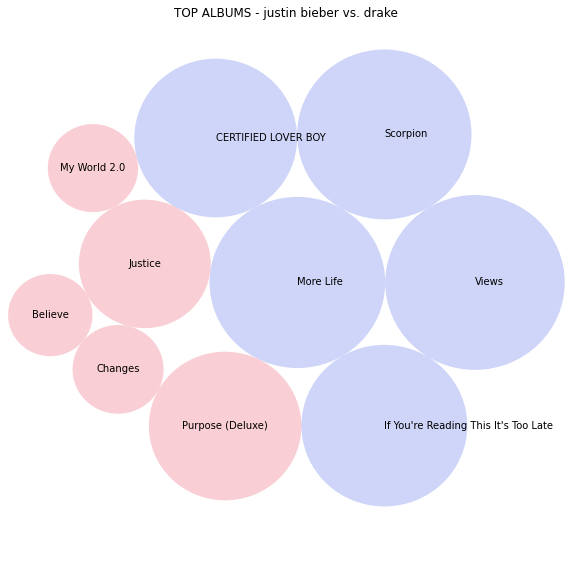

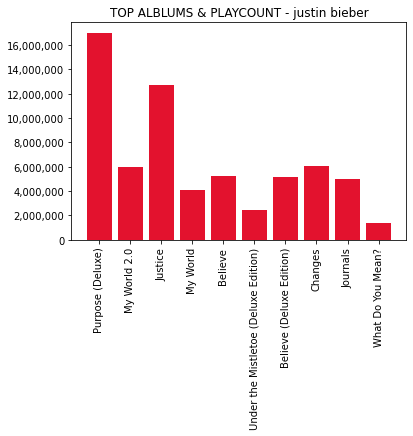

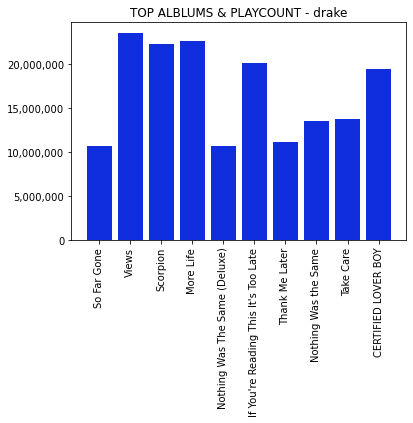

drake is the more popular artist!

----------------------------------------------------------------------------------------------------

TOP 10 SONG(S) YOU MAY ALSO LIKE:
----------------------------------------------------------------------------------------------------
Destiny's Child - Say My Name
Normani - Wild Side (feat. Cardi B)
Normani - Motivation
Zayn - PILLOWTALK
Selena Gomez - Good for You
Little Mix - Woman Like Me (feat. Nicki Minaj)
Jhené Aiko - P*$$Y Fairy (OTW)
Ciara - Like a Boy
Kehlani - Toxic
Jesy Nelson - Boyz (feat. Nicki Minaj)

----------------------------------------------------------------------------------------------------

TOP 9 ARTIST(S) YOU MAY ALSO LIKE:
----------------------------------------------------------------------------------------------------
Chris Brown
Post Malone
The Weeknd
Usher
Nicki Minaj
Jeremih
Omarion
Ty Dolla $ign
Bryson Tiller


In [5]:
if __name__ == '__main__':

    #---------------------------------------------------------------------------------------------------------------------------
    # output search results
    #---------------------------------------------------------------------------------------------------------------------------
    search_sim_artist(artist0)
    print()
    search_sim_artist(artist1)
    #---------------------------------------------------------------------------------------------------------------------------
    # output search details
    #---------------------------------------------------------------------------------------------------------------------------
    print('\n'+ '-' * 100 + '\n')
    search_artist_bio(artist0)
    print()
    search_artist_bio(artist1)
    #---------------------------------------------------------------------------------------------------------------------------
    # output visual 1
    #---------------------------------------------------------------------------------------------------------------------------
    print('\n'+ '-' * 100 + '\n')
    main_circles_v2(artist0, artist1)
    #---------------------------------------------------------------------------------------------------------------------------
    # output visual 2
    #---------------------------------------------------------------------------------------------------------------------------
    print('\n'+ '-' * 100 + '\n')
    main_bars(artist0, artist1)
    #---------------------------------------------------------------------------------------------------------------------------
    # output visual 3
    #---------------------------------------------------------------------------------------------------------------------------
    print('\n'+ '-' * 100 + '\n')
    main_songs(artist0, song0, artist1, song1, debug=False)
    #---------------------------------------------------------------------------------------------------------------------------
    # output visual 4
    #---------------------------------------------------------------------------------------------------------------------------
    print('\n'+ '-' * 100 + '\n')
    main_artists(artist0, artist1)